# Classificação para café (adaptar para uvas)

In [1]:
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt

In [2]:
from skimage.feature import hog

In [3]:
import cPickle as pickle

## Carregar base de dados

In [6]:
pkl_file = open('../data/guaspari/2017-04-27/grape_dataset_1313.pickle', 'r')
grape_dataset = pickle.load(pkl_file)
pkl_file.close()


<IPython.core.display.Javascript object>


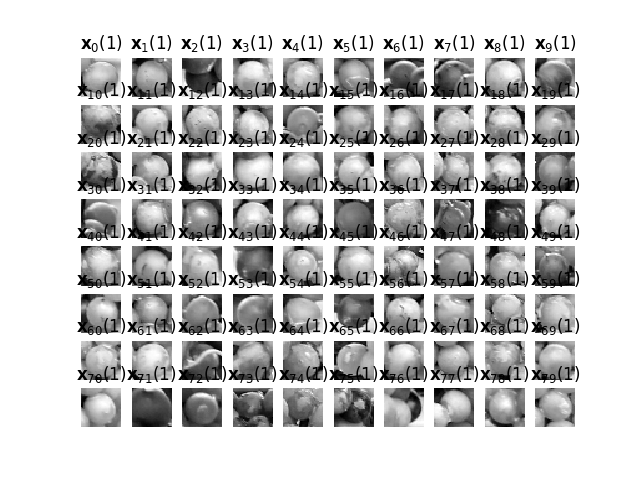

In [7]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    x = grape_dataset['data'][i]
    plt.imshow(x.reshape(32,32), cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.title(r'$\mathbf{x}_{%d} (%d)$' % (i, grape_dataset['target'][i]))

Por hora, vamos excluir do conjunto as amostras de uva da classe 2:

In [15]:
data = grape_dataset['data'].copy()
data = (data - data.min())/(data.max() - data.min())


<IPython.core.display.Javascript object>


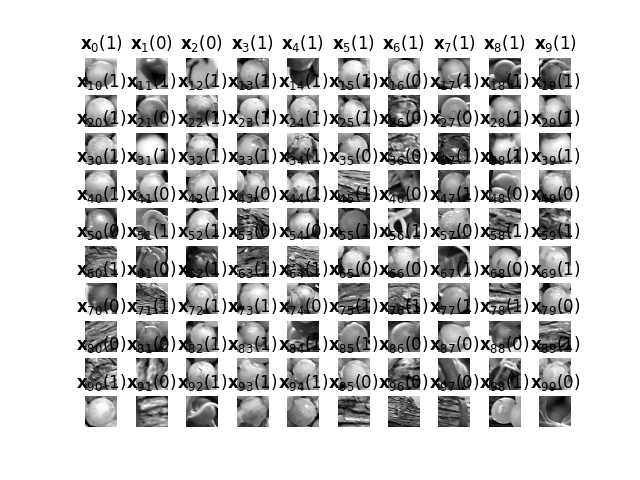

In [16]:
for i in range(100):
    plt.subplot(10, 10, i+1)
    x = data[i]
    plt.imshow(x.reshape(32,32), cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.title(r'$\mathbf{x}_{%d} (%d)$' % (i, grape_dataset['target'][i]))

In [17]:
Y = grape_dataset['target']
X_grape = data[Y == 1]
X_notgrape = data[Y == 0]

n_grape_samples = X_grape.shape[0]
n_notgrape_samples = X_notgrape.shape[0]

print n_grape_samples, n_notgrape_samples


608 1232


<IPython.core.display.Javascript object>


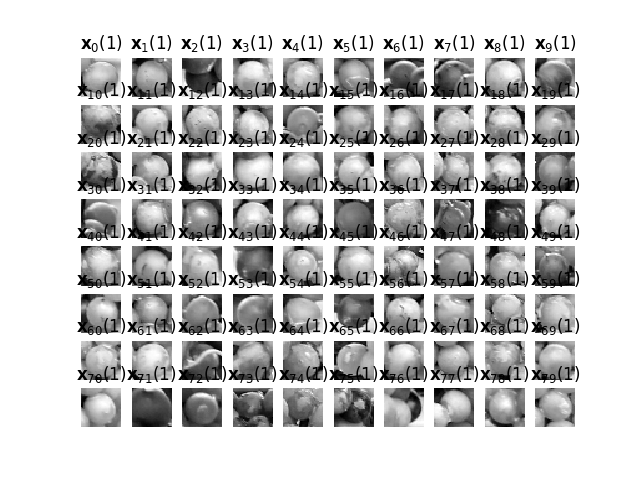

In [18]:
for i in range(80):
    plt.subplot(8, 10, i+1)
    x = X_grape[i]
    plt.imshow(x.reshape(32,32), cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.title(r'$\mathbf{x}_{%d} (1)$' % i)

### Ampliação da base de dados

In [20]:
def nudge_dataset_rot90(X, Y):
    """
    This produces a dataset 2 times bigger than the original one,
    by rotating 32x32 images in X around 90 (180 and 270 degrees)
    """
    
    X90 = [np.rot90(x.reshape(32,32)).reshape(-1) for x in X]
#    X180 = [np.rot90(x.reshape(32,32)).reshape(-1) for x in X90]
#    X270 = [np.rot90(x.reshape(32,32)).reshape(-1) for x in X180]
    
    X = np.concatenate([X, X90])
    #Y = np.concatenate([Y for _ in range(4)], axis=0)
    Y = np.concatenate([Y, Y], axis=0)
    return X, Y

In [21]:
X_grape_nud, Y_grape_nud = nudge_dataset_rot90(X_grape, np.ones(n_grape_samples))
print X_grape_nud.shape
print Y_grape_nud.shape

(1216, 1024)
(1216,)


In [22]:
n_grape_samples = X_grape_nud.shape[0]
print n_grape_samples
print n_notgrape_samples

1216
1232


O número de amostras de uva e não-uva agora é similar:

In [23]:
X_nud = np.concatenate([X_grape_nud, X_notgrape[0:n_notgrape_samples,:]])
Y_nud = np.concatenate([np.ones(n_grape_samples), np.zeros(n_notgrape_samples)])
print X_nud.shape
print Y_nud.shape

(2448, 1024)
(2448,)


Se usarmos `hog` com `visualize=True` ele devolve uma imagem que é uma visualização gráfica do descritor HoG:

In [24]:
#X_hog = np.array([hog(x.reshape(32,32), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(4, 4)) 
#                  for x in X_nud])
res_hog = [hog(x.reshape(32,32), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(4, 4), visualise=True) 
       for x in X_nud]

/usr/local/lib/python2.7/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [25]:
print res_hog[0][0].shape  # Descritor HoG da amostra 0
print res_hog[0][1].shape  # Imagem de visualização para a amostra 0

(144,)
(32, 32)


In [26]:
X_hog = np.array([descr for descr, vis in res_hog])

In [27]:
X_hog.shape

(2448, 144)

## Visualizando HoG

Uvas:

<IPython.core.display.Javascript object>


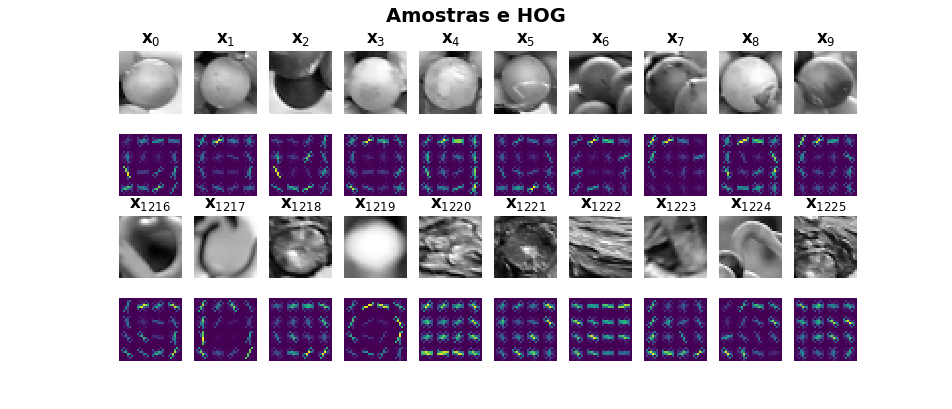

In [37]:
fig = plt.figure() 
fig.suptitle('Amostras e HOG', fontsize=14, fontweight='bold')
for i in range(10):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_nud[i].reshape(32,32), cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.title(r'$\mathbf{x}_{%d}$' % i)
    
    plt.subplot(4, 10, i+1 + 10)
    plt.imshow(res_hog[i][1], cmap=plt.cm.viridis, interpolation='nearest')
    plt.axis('off')
    #plt.title('Uva')    
    
for i in range(10):
    shift = n_grape_samples
    j = i + shift # j está no intervalo de amostras não-uva
    plt.subplot(4, 10, i+1 + 20)
    plt.imshow(X_nud[j].reshape(32,32), cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('off')
    plt.title(r'$\mathbf{x}_{%d}$' % j)
    
    plt.subplot(4, 10, i+1 + 30)
    plt.imshow(res_hog[j][1], cmap=plt.cm.viridis, interpolation='nearest')
    plt.axis('off')
    #plt.title(u'Não-uva') 

In [38]:
fig.savefig('/tmp/figura1.png', dpi=200)

Não-uva:

<IPython.core.display.Javascript object>


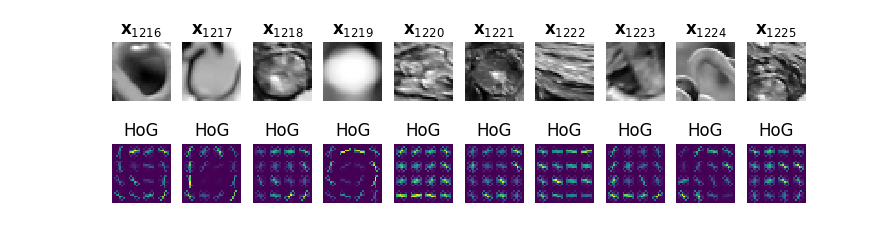

In [28]:
from sklearn.model_selection import train_test_split

**IMPORTANTE**: Note que `train_test_split` *embaralha* as amostras, de modo que nossa lista de dados que contém *todas* as uvas primeiro, não prejudica o processo de aprendizado de máquina!

In [29]:
# ----> OLHA O ERRO AQUI: X_train, X_test, Y_train, Y_test = train_test_split(X_nud, Y_nud, test_size=0.2, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X_hog, Y_nud, test_size=0.2, random_state=0)
print X_train.shape
print Y_train.shape

print X_test.shape
print Y_test.shape


(1958, 144)
(1958,)
(490, 144)
(490,)


## Treinamento

In [30]:
from sklearn.metrics import classification_report

### Cross-validation

In [32]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [34]:
from sklearn.model_selection import GridSearchCV

### Support Vector Machines

In [35]:
from sklearn.svm import SVC

In [36]:
svc = SVC()

#### Hyperparameters

In [37]:
svc_params = {'C': [1, 10, 100, 1000], 
              'kernel': ['linear', 'poly', 'rbf']
            }

In [38]:
grid_search = GridSearchCV(svc, svc_params, n_jobs=-1, verbose=1, cv=5)
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   16.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [39]:
best_params = grid_search.best_estimator_.get_params()
for param_name in sorted(svc_params.keys()):
    print("%s: %r" % (param_name, best_params[param_name]))

C: 10
kernel: 'linear'


In [41]:
svc = grid_search.best_estimator_
cross_val_score(svc, X_train, Y_train, cv=5, n_jobs=-1)

array([ 0.81632653,  0.78316327,  0.79081633,  0.81585678,  0.81841432])

In [42]:
svc.fit(X_train, Y_train)
print classification_report(Y_test, svc.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.78      0.83      0.80       254
        1.0       0.80      0.75      0.77       236

avg / total       0.79      0.79      0.79       490



### K-vizinhos

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
kneigh = KNeighborsClassifier()

#### Hyperparameters

In [45]:
kneigh_params = {'n_neighbors': [5, 10, 15, 20]}

In [46]:
grid_search = GridSearchCV(kneigh, kneigh_params, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [47]:
best_params = grid_search.best_estimator_.get_params()
for param_name in sorted(kneigh_params.keys()):
    print("%s: %r" % (param_name, best_params[param_name]))

n_neighbors: 20


In [49]:
kneigh = grid_search.best_estimator_
cross_val_score(kneigh, X_train, Y_train, cv=5, n_jobs=-1)

array([ 0.76020408,  0.76785714,  0.78061224,  0.79795396,  0.79283887])

In [50]:
kneigh.fit(X_train, Y_train)
print classification_report(Y_test, kneigh.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.75      0.87      0.81       254
        1.0       0.84      0.69      0.76       236

avg / total       0.79      0.79      0.78       490



### Naïve Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

In [52]:
gnb = GaussianNB()

In [54]:
cross_val_score(gnb, X_train, Y_train, cv=5, n_jobs=-1)

array([ 0.7372449 ,  0.77806122,  0.75255102,  0.8056266 ,  0.75703325])

In [55]:
gnb.fit(X_train, Y_train)
print classification_report(Y_test, gnb.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.80      0.69      0.74       254
        1.0       0.71      0.81      0.76       236

avg / total       0.76      0.75      0.75       490



### Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [57]:
tclf = DecisionTreeClassifier()

In [59]:
cross_val_score(tclf, X_train, Y_train, cv=5, n_jobs=-1)

array([ 0.71938776,  0.73469388,  0.71683673,  0.71867008,  0.71867008])

In [60]:
tclf.fit(X_train, Y_train)
print classification_report(Y_test, tclf.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.73      0.73      0.73       254
        1.0       0.71      0.70      0.71       236

avg / total       0.72      0.72      0.72       490



### Regressão logística

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
logistic = LogisticRegression()

In [63]:
cross_val_score(logistic, X_train, Y_train, cv=5, n_jobs=-1)

array([ 0.79081633,  0.74744898,  0.75      ,  0.81074169,  0.80306905])

In [64]:
logistic.fit(X_train, Y_train)
print classification_report(Y_test, logistic.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.77      0.77      0.77       254
        1.0       0.75      0.75      0.75       236

avg / total       0.76      0.76      0.76       490

